### Multi-criteria optimization

In [1]:
using CSV
using DataFrames
using Statistics
using JuMP
using MultiJuMP
using Ipopt
using Plots

prices = DataFrame(CSV.File("10_stocks_3yr.csv"))
prices[1:5,:]


Row,date,open,close,Name
,Date,Float64,Float64,String7
1,2015-01-02,111.39,109.33,AAPL
2,2015-01-05,108.29,106.25,AAPL
3,2015-01-06,106.54,106.26,AAPL
4,2015-01-07,107.2,107.75,AAPL
5,2015-01-08,109.23,111.89,AAPL


In [2]:
prices.rateOfRet = (prices.close .- prices.open) ./ prices.open
dats = unstack(prices, :date, :Name, :rateOfRet)
dats


Row,date,AAPL,AMZN,BRK.B,FB,GOOGL,GOOG,JNJ,JPM,MSFT,XOM
,Date,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?
1,2015-01-02,-0.0184936,-0.0129887,-0.0153795,-0.00165436,-0.00572662,-0.00793936,-0.00504522,-0.00207601,0.00214316,0.00628726
2,2015-01-05,-0.0188383,-0.0156998,-0.0121632,-0.0101308,-0.0145879,-0.0179452,-0.00660413,-0.0243313,-0.000970455,-0.0196526
3,2015-01-06,-0.00262812,-0.022995,-0.00541859,-0.0139842,-0.0266282,-0.0253204,-0.0101591,-0.0273747,-0.0157395,-0.00476507
4,2015-01-07,0.0051306,0.00309244,0.00635393,-0.00794685,-0.0113514,-0.0116371,0.0158791,-0.0136918,0.00543715,0.000772201
5,2015-01-08,0.0243523,0.000466169,0.00511288,0.0186995,0.0107675,0.00941786,0.00311145,0.0070035,0.0179679,0.0107397
6,2015-01-09,-0.00585781,-0.0150922,-0.0143752,-0.00588235,-0.0146798,-0.017018,-0.0146479,-0.0227273,-0.00882168,-0.00216685
7,2015-01-12,-0.0297513,-0.0206681,-0.011203,-0.0143885,-0.00436664,-0.00482887,-0.00560996,-0.00759109,-0.0172923,-0.0099737
8,2015-01-13,-0.0108588,-0.0092107,-0.00880293,-0.0100997,-0.00153212,-0.00533237,-0.00644917,-0.00708741,-0.0130935,-0.0096831
9,2015-01-14,0.00696992,0.00459014,0.00373464,-0.00183198,0.0110108,0.0125745,0.00134797,-0.00175716,-0.00010879,0.00888139


In [3]:
const avg_rets = [ mean(col) for col in eachcol(dats[:,2:end])]
const cov_mx = cov(Matrix(dats[:,2:end]))


10×10 Matrix{Float64}:
 0.000141444  7.05342e-5  3.95975e-5  …  4.82517e-5  6.54475e-5   3.27512e-5
 7.05342e-5   0.00017212  3.24832e-5     4.15248e-5  7.1176e-5    2.19292e-5
 3.95975e-5   3.24832e-5  6.3866e-5      5.32424e-5  3.94755e-5   3.80986e-5
 7.82499e-5   9.96999e-5  3.10998e-5     3.68132e-5  6.77914e-5   1.94835e-5
 6.32639e-5   9.59114e-5  3.23086e-5     3.73887e-5  6.43079e-5   2.24464e-5
 6.48236e-5   9.63896e-5  3.3117e-5   …  3.76297e-5  6.49578e-5   2.21649e-5
 2.87843e-5   3.10713e-5  2.96455e-5     2.77098e-5  3.11186e-5   2.9434e-5
 4.82517e-5   4.15248e-5  5.32424e-5     9.97947e-5  4.48171e-5   4.17071e-5
 6.54475e-5   7.1176e-5   3.94755e-5     4.48171e-5  0.000110309  2.90038e-5
 3.27512e-5   2.19292e-5  3.80986e-5     4.17071e-5  2.90038e-5   9.13447e-5

In [4]:
m = multi_model(Ipopt.Optimizer)
@variable(m, 0 <= x[i=1:10] <= 1)
@constraint(m,sum(x) == 1)

@variable(m, risk)
@constraint(m, risk == x'*cov_mx*x)

@variable(m, rets)
@constraint(m, rets == avg_rets' * x)

@NLexpression(m, f_risk, risk)
@NLexpression(m, f_rets, rets)

iv1 =  fill(0.1, 10) # Initial guess
obj1 = SingleObjective(f_risk, sense = MOI.MIN_SENSE,
                        iv = Dict{String,Any}("x[$i]" => iv1[i] for i in 1:length(iv1)))
obj2 = SingleObjective(f_rets, sense = MOI.MAX_SENSE)

md = get_multidata(m)
md.objectives = [obj1, obj2]
md.pointsperdim = 20;


In [5]:
optimize!(m, method = NBI(false))


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:      122
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:       12
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       10
                     variables with only upper bounds:        0
Total number of equality constraints.................:        3
Total number of inequality c

OPTIMAL::TerminationStatusCode = 1

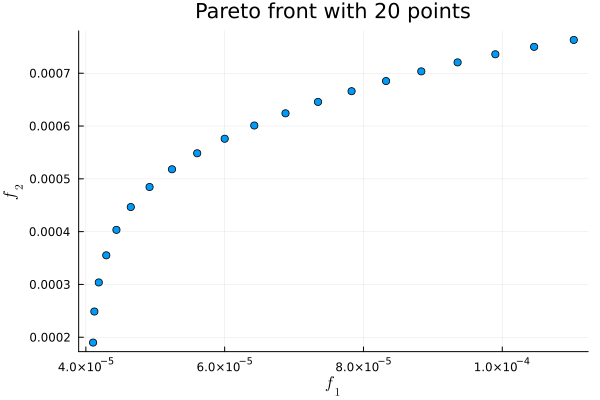

In [6]:
pltnbi = Plots.plot(md)
